In [1]:
import numpy as np
import pyemma
import matplotlib
import matplotlib.pyplot as plt
import pyemma.plots as mplt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7.0, 5.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

In [2]:
def filter(f, stride):
    for i, line in enumerate(f):
        if (not i%stride):
            yield line

In [3]:
fname = '/srv/data/dibakma/potentialMSM/2DmodifiedLJtraj/traj_eps2_box6_initmin'
truncTrajs = []
trajs = []
bathtoMSMs = []
MSMtobaths = []
trajAssignment = []
fileIndex = 0
for number in range(0,16):
    with open(fname+str(number)+'.txt') as f:
        traj = np.genfromtxt(filter(f, 1))
        trajs.append(traj[:,1:3])
        abs = np.linalg.norm(traj[:,1:3], axis = 1)
        MSMdomain = (abs < 2.7)
        bathtoMSM = np.where(np.logical_and(~MSMdomain[:-1], MSMdomain[1:]) )[0]+1
        MSMtobath = np.where(np.logical_and(MSMdomain[:-1], ~MSMdomain[1:]) )[0]+1
        #make sure both arrays have the same lenght
        if MSMdomain[0]:
            bathtoMSM = np.insert(bathtoMSM, 0, 0)
        if MSMdomain[-1]:
            MSMtobath = np.append(MSMtobath, len(MSMdomain))
        bathtoMSMs.append(bathtoMSM)
        MSMtobaths.append(MSMtobath)
        for i in range(0, len(bathtoMSM)):
            trajAssignment.append(fileIndex)
            truncTrajs.append(traj[bathtoMSM[i]:MSMtobath[i],1:3])
        fileIndex += 1

In [4]:
fullLength = 0
truncLength = 0
for i in range(0, len(truncTrajs)):
    truncLength += truncTrajs[i].shape[0]
for i in range(0, len(trajs)):
    fullLength += trajs[i].shape[0]
print truncLength/float(fullLength)

0.6141766875


In [5]:
fileIndex = np.array(fileIndex)
index = 0
for i in range(0, len(trajs)):
    lengths = (MSMtobaths[i] - bathtoMSMs[i])
    for i in range(0, len(lengths)):
        if lengths[i] != len(truncTrajs[index]):
            print i
        index += 1

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 <a list of 7 Text yticklabel objects>)

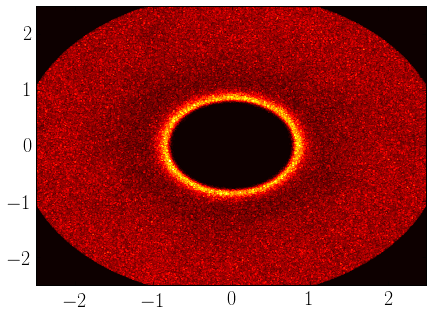

In [5]:
X = np.arange(-2.5, 2.5, 0.01)
Y = np.arange(-2.5, 2.5, 0.01)
Ztrunc = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in truncTrajs:
    hist = np.histogram2d(traj[:,0], traj[:,1], bins = [X, Y], normed=False)
    Ztrunc += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Ztrunc, 100, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("/home/mi/dibakma/Dokumente/reactionMSM/modifiedLJ/trajectory_histogram.png")

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 <a list of 7 Text yticklabel objects>)

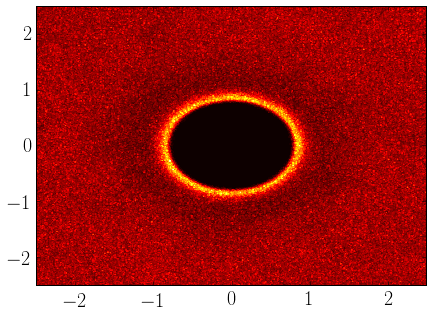

In [6]:
X = np.arange(-2.5, 2.5, 0.01)
Y = np.arange(-2.5, 2.5, 0.01)
Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in trajs:
    hist = np.histogram2d(traj[:,0], traj[:,1], bins = [X, Y], normed=False)
    Zfull += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Zfull, 100, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

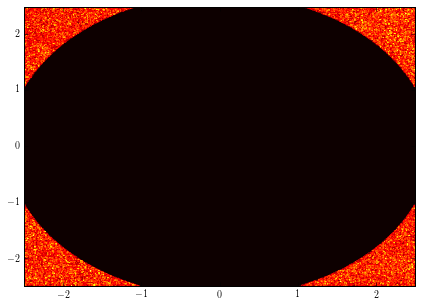

In [7]:
cp = plt.contourf(Zfull-Ztrunc, 100, cmap=plt.cm.hot, extent=extent)

(0, 100)

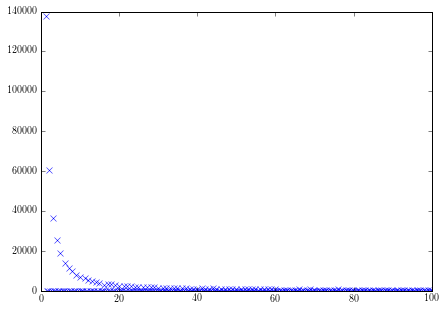

In [8]:
lengths = np.zeros(len(truncTrajs))
for i in range(0, len(truncTrajs)):
    lengths[i] = len(truncTrajs[i])
hist, bins = np.histogram(lengths, bins='auto')
plt.plot((bins[1:]+bins[:-1])/2,hist, 'x')
plt.xlim([0,100])
#print np.sum(lengths)/(20*1000000)

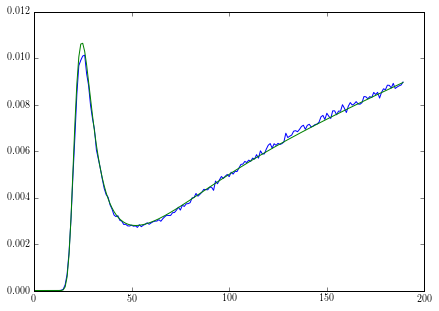

In [9]:
epsilon = 2
sigma = 1.
a = 1.
b = 9.
c = 2.
def potential(r):
    R = np.linalg.norm(r)
    rhat = r/R
    Rinv = 1./R
    Rinv3 = Rinv**3
    Rinv6 = Rinv3**2
    sig3 = pow(sigma, 3)
    return epsilon * sig3**2 * Rinv6* (a * sig3**2 * Rinv6 - b*sig3 * Rinv3 / 3 + c )

bin_edges  = np.arange(0.6,2.51, 0.01)
radialHist = np.zeros(len(bin_edges)-1)
centers = (bin_edges[:-1] + bin_edges[1:])/2.
for traj in truncTrajs:
    hist, bins = np.histogram(np.linalg.norm(traj, axis = 1), bins = bin_edges)
    radialHist += hist

Epot = np.zeros_like(centers)
for i in range(0, len(centers)):
    Epot[i] = potential(centers[i])
stationaryDistribution = centers*np.exp(-Epot)
plt.plot(radialHist/sum(radialHist))
plt.plot(stationaryDistribution/sum(stationaryDistribution))

In [10]:
clustering = pyemma.coordinates.cluster_kmeans(truncTrajs, k=200, max_iter = 10000)

kmeans iterations:   0% (    1/10000) [                            ] eta --:-- /02-12-16 14:30:30 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 2 steps.
kmeans iterations: 100% (10000/10000) [############################] eta --:-- |

In [11]:
dtrajsClustering = clustering.dtrajs

getting output of KmeansClustering: 100% (453269/453269) [#########] eta 00:00 /

In [12]:
maxima = np.zeros(len(dtrajsClustering))
for i in range(0, len(dtrajsClustering) ):
    maxima[i] = np.amax(dtrajsClustering[i])
print np.amax(maxima)

199.0


In [13]:
dtrajs = []
counter = 0

for i in range(0, len(trajs)):
    dtraj = np.ones(len(trajs[i]), dtype=int)*100 #assign state 100 to bath and reinsert truncated discrete trajectories
    MSMdomain = np.where(np.linalg.norm(trajs[i], axis=1) < 2.7)
    bathtoMSM = bathtoMSMs[i]
    MSMtobath = MSMtobaths[i]
    assert(np.all(bathtoMSM.shape == MSMtobath.shape))
    lenghts = MSMtobath - bathtoMSM
    for i in range(0, len(bathtoMSM)):
        if np.all(dtraj[bathtoMSM[i]:MSMtobath[i]].shape != dtrajsClustering[counter].shape):
            print "should be shape: ",dtraj[bathtoMSM[i]:MSMtobath[i]].shape, "is shape: ", dtrajsClustering[counter].shape
            print counter
            print dtrajsClustering[counter]
            print dtrajsClustering[counter+1]
        dtraj[bathtoMSM[i]:MSMtobath[i]] = dtrajsClustering[counter]
        counter += 1
    assert(np.all(dtraj[MSMdomain] != 100) )
    dtrajs.append(dtraj)

AssertionError: 

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in divide
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


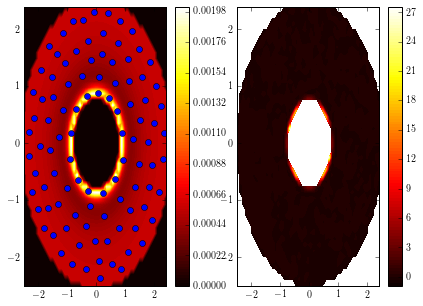

In [9]:
centers = clustering.clustercenters
X = np.arange(-2.5, 2.5, 0.1)
Y = np.arange(-2.5, 2.5, 0.1)
Z = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in truncTraj:
    hist = np.histogram2d(traj[:,0], traj[:,1], bins = [X, Y], normed=False)
    Z += hist[0]
X_centers = (X[1:] + X[:-1])/2.
Y_centers = (Y[1:] + Y[:-1])/2.
stat_distr = np.zeros([X_centers.size, Y_centers.size])
for i in range(0, X_centers.size):
    for j in range(0, Y_centers.size):
        R = np.linalg.norm([ X_centers[i], Y_centers[j] ])
        if R < 2.5:
            stat_distr[i,j] = np.exp(-potential(R) )
stat_distr /= stat_distr.sum()
Z /= Z.sum()
extent = [X[0], X[-1], Y[0], Y[-1]]
boundary = np.where(np.linalg.norm(centers, axis=1) > 2.2)
plt.subplot2grid((1,2), (0,0))
cp = plt.contourf(stat_distr, 100, cmap=plt.cm.hot, extent=extent)
plt.plot(centers[:,0], centers[:,1], 'bo')
plt.colorbar(cp)
plt.subplot2grid((1,2), (0,1))
cp = plt.contourf(np.log((Z)/stat_distr), 100, cmap=plt.cm.hot, extent=extent)
plt.colorbar(cp)

In [32]:
#intdtrajs = []
#for i in range(0, len(dtrajs)):
#    intdtrajs.append(dtrajs[i].astype(int))
its = pyemma.msm.its(dtrajs, lags = 50)

estimating MaximumLikelihoodMSM: 100% (9/9) [######################] eta 00:00 -

(array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
          1.00000000e+01,   1.00000000e+02,   1.00000000e+03]),
 <a list of 6 Text yticklabel objects>)

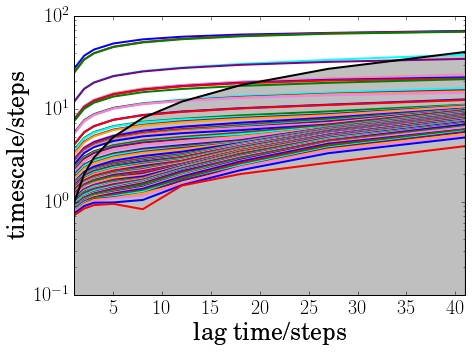

In [33]:
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("/home/mi/dibakma/Dokumente/reactionMSM/modifiedLJ/implied_timescales.pdf", bbox_inches='tight')

In [34]:
msm_lag = 5
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=True)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 <a list of 7 Text yticklabel objects>)

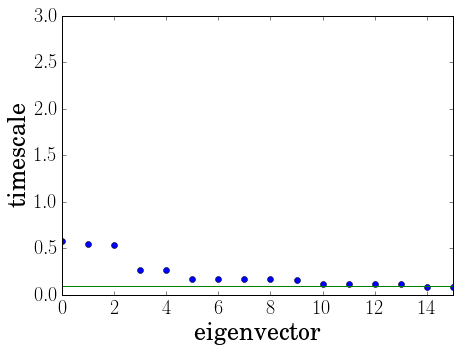

In [25]:
plt.plot(M.timescales()*0.01, 'o')
line = np.ones(30)*msm_lag*0.01
plt.plot(line, '-')
plt.xlim([0, 15])
plt.ylim([0,3])
plt.ylabel(r"timescale", fontsize = 24)
plt.xlabel(r"eigenvector", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("/home/mi/dibakma/Dokumente/reactionMSM/modifiedLJ/timescales.pdf", bbox_inches='tight')

In [179]:
#save MSM data
#filename = '/srv/data/dibakma/potentialMSM/2DmodifiedLJtraj/eps2/MSMdata/300centers_lag500'
#np.savetxt(filename+'_Tmatrix.txt', M.transition_matrix)
#np.savetxt(filename+'_centers.txt', clustering.clustercenters)

[ 58.11829466  54.89077944  54.23606066  26.84218085  26.51472448
  17.41743644  17.32805096  16.98494571  16.86003716  15.85409681]
58.1182946629
(101,)


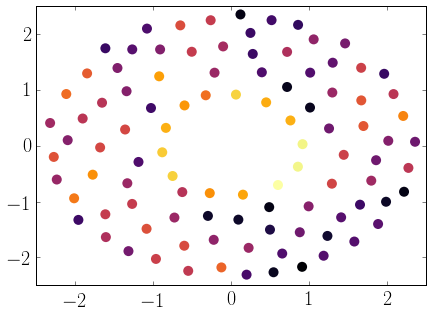

In [26]:
vectors = M.eigenvectors_left()
value = M.eigenvalues()
print M.timescales()[:10] 
print -msm_lag/np.log(value[1])
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5,2.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
cc = clustering.clustercenters
print vectors[0].shape
sc = plt.scatter(cc[:,0], cc[:,1], c=vectors[0][:-1], cmap=plt.cm.inferno, linewidths = 0, s=100)
#plt.savefig('/home/mi/dibakma/Dokumente/reactionMSM/modifiedLJ/eigenvectors/12.pdf')

# Compare stationary distribution to expected distribution

In [16]:
epsilon = 2.
sigma = 1.
a = 1.
b = 9.
c = 2.
def potential(r):
    R = np.linalg.norm(r)
    rhat = r/R
    Rinv = 1./R
    Rinv3 = Rinv**3
    Rinv6 = Rinv3**2
    sig3 = pow(sigma, 3)
    return epsilon * sig3**2 * Rinv6* (a * sig3**2 * Rinv6 - b*sig3 * Rinv3 / 3 + c )

def voronoi(traj, centers):
    ltraj = traj.shape[0]
    ncenters = centers.shape[0]
    clustering = np.zeros(ltraj, dtype = int)
    for i in range(0, ltraj):
        index = np.argmin( np.linalg.norm(centers - traj[i,:], axis = 1) )
        clustering[i] = index
    return clustering

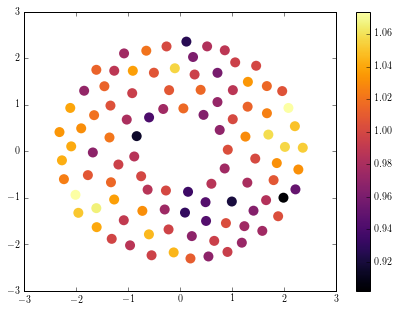

In [30]:
#create grid
x = np.arange(-2.5, 2.5, 0.01)
y = np.arange(-2.5, 2.5, 0.01)
grid = np.zeros([x.size * y.size, 2])
for i in range(0, x.size):
    for j in range(0, y.size):
        index = i * y.size + j
        grid[index,:] = [x[i], y[j]]
cc = clustering.clustercenters
membership = voronoi(grid, cc)
pi_grid = np.zeros(grid.shape[0])
for i in range(0, grid.shape[0]):
    if np.linalg.norm(grid[i,:]) < 2.5:
        pi_grid[i] = np.exp(-potential(grid[i,:]))
pi_cluster = np.zeros(cc.shape[0])
for i in range(0, cc.shape[0]):
    indices = np.where(membership == i)[0]
    pi_cluster[i] = np.sum(pi_grid[indices])
#normalize
pi_cluster /= pi_cluster.sum()
r2 = M.eigenvectors_left()[0][:-1]
#renormalize r2
r2 /= np.sum(r2)

pi = np.zeros_like(r2)
for i in range(0, cc.shape[0]):
    pi[i] = np.exp(-potential(cc[i,:]))
pi /= pi.sum()
diff = r2/pi_cluster
sc = plt.scatter(cc[:,0], cc[:,1], c=diff, cmap=plt.cm.inferno, linewidths = 0, s=100)
plt.colorbar(sc)

0.878931898536


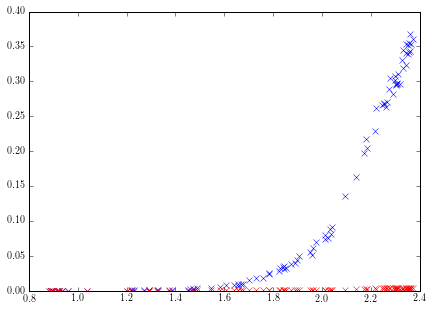

In [36]:
r = np.linalg.norm(cc, axis = 1)
plt.plot(r, M.transition_matrix[:100, 100], 'bx')
plt.plot(r, M.transition_matrix[100, :100], 'rx')
print np.sum(M.transition_matrix[100, 100])

# Let's have a look at left eigenvectors

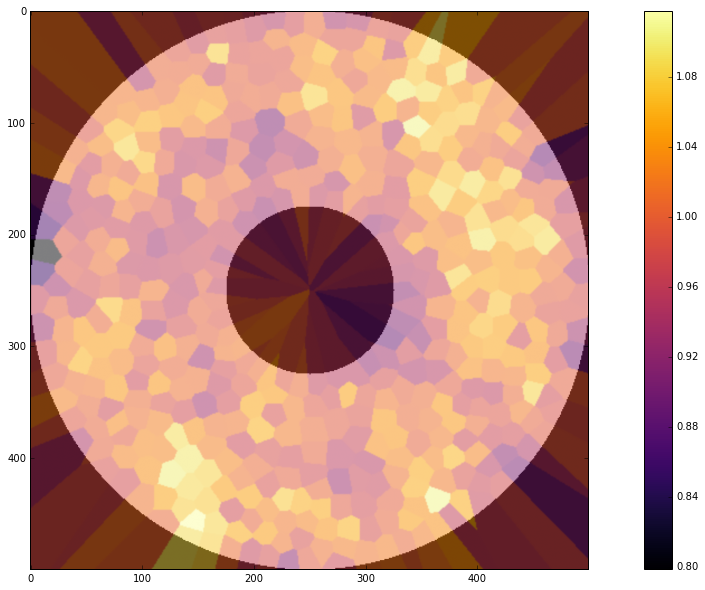

In [16]:
res=0.01
boundary=2.5
pixels=int(boundary/res)
x=np.arange(-boundary, boundary, res)
y=np.arange(-boundary, boundary, res)
img=np.zeros([x.shape[0], y.shape[0]])
for i in range(0, x.shape[0]):
    for j in range(0, y.shape[0]):
        position=np.array([[x[i], y[j]]])
        membership=voronoi(position, cc)
        img[i,j]=diff[membership]

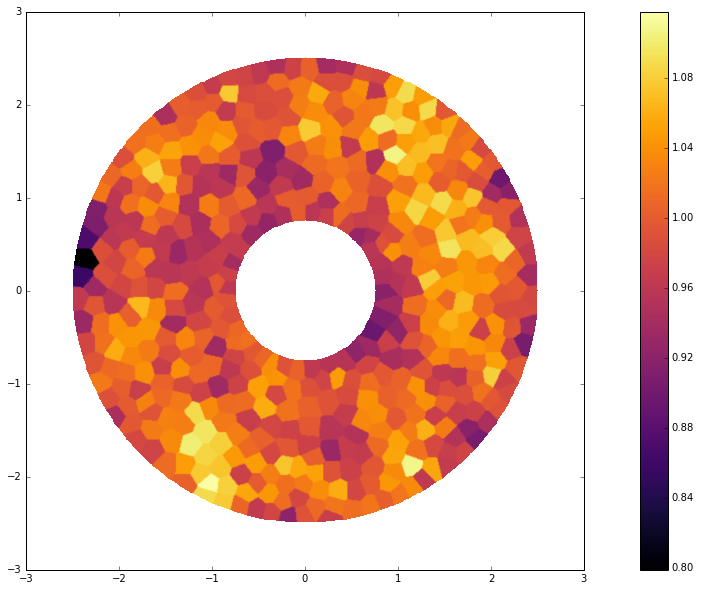

In [18]:
im = plt.imshow(img, extent=[-2.5, 2.5, -2.5, 2.5], cmap=plt.cm.inferno, interpolation='bicubic')
x = np.arange(-2.6, 2.6, 0.01)
y = np.arange(-2.6, 2.6, 0.01)
grid = np.zeros([x.size * y.size, 2])
for i in range(0, x.size):
    for j in range(0, y.size):
        index = i * y.size + j
        grid[index,:] = [x[i], y[j]]
indices=np.where(np.logical_or(np.linalg.norm(grid, axis=1) > 2.5,  np.linalg.norm(grid, axis=1) < 0.75 ) )
plt.plot(grid[indices,0], grid[indices,1], 'w,', linewidth=0, fillstyle='full', markersize=0.01)
#plt.imshow(mask, extent=[-2.5, 2.5, -2.5, 2.5], cmap=plt.cm.gray, alpha=0.5)
plt.colorbar(im)

In [15]:
membership_traj = voronoi(traj, cc)

100
100
(array([], dtype=int64),)
[ 0.          0.0002677   0.00029857  0.00040703  0.000559    0.0004904
  0.00070932  0.00076079  0.00085397  0.00140695  0.00163675  0.00148454
  0.00155843  0.00142851  0.00240121  0.00169312  0.00331648  0.00249195
  0.00416913  0.00283833  0.00258845  0.00420374  0.0025305   0.00303297
  0.00343911  0.00260777  0.00420379  0.00308963  0.00389645  0.00412707
  0.0035065   0.00323296  0.00467799  0.00448862  0.00403757  0.0044909
  0.00591181  0.00480311  0.00432529  0.00508903  0.00468369  0.00581143
  0.00725245  0.00514166  0.00710858  0.00436906  0.00688661  0.00674004
  0.00561007  0.00610265  0.00985532  0.00686393  0.00759008  0.0076613
  0.01271193  0.00549491  0.00778691  0.00771074  0.0076339   0.00661095
  0.00736061  0.00864862  0.00875617  0.00905992  0.00917439  0.0110831
  0.01162494  0.01008935  0.00809538  0.01011705  0.01218661  0.00846192
  0.01015159  0.00821592  0.00922863  0.00890138  0.00956947  0.01084123
  0.01233629  0.01090

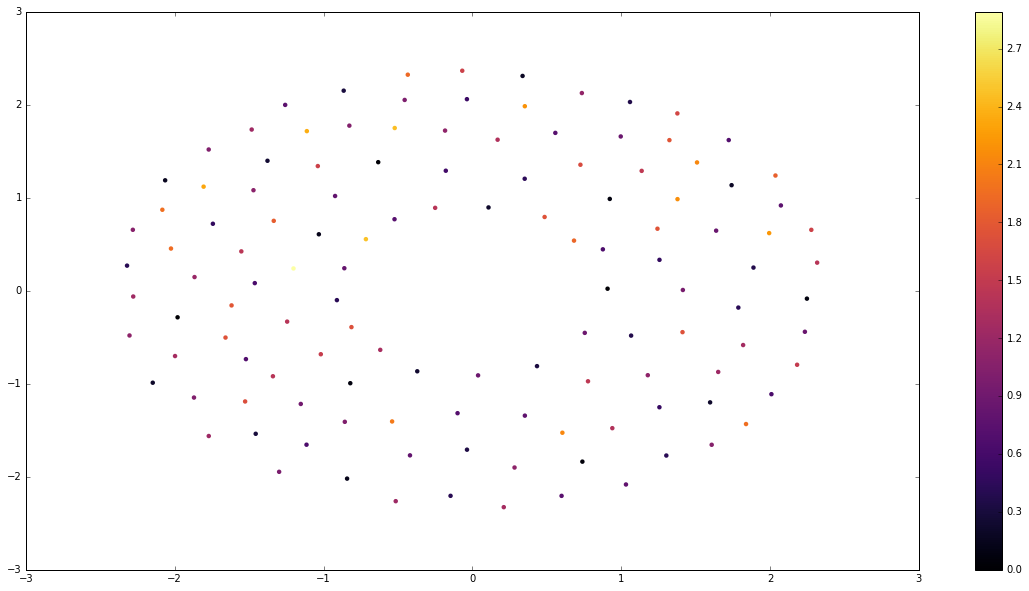

In [16]:
dtraj = clustering.dtrajs
pi_simulation = np.zeros(cc.shape[0], dtype = float)
for i in range(0, cc.shape[0]):
    indices = np.where(membership_traj == i)
    pi_simulation[i] = np.sum(membership_traj[indices])
pi_simulation /= pi_simulation.sum()
quotient = pi_simulation/pi_cluster
sc = plt.scatter(cc[:,0], cc[:,1], c=quotient, cmap=plt.cm.inferno, linewidths = 0)
plt.colorbar(sc)